# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as a Jupyter notebook document. Before exporting the notebook to ipynb, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> Notebook (.ipynb)**. Include the finished document along with this notebook as your submission. 


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [ ]:
#https://www.kaggle.com/darkwingduck1987/road-signs-with-cnn-vgg16

In [ ]:
#https://github.com/hparik11/German-Traffic-Sign-Recognition/blob/master/German_Traffic_Sign_Classifier.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') # You can either use your drive or work directly on colab with temporary import

MessageError: ignored

In [ ]:
#@title Run Me Please
!pip -q install pydot_ng
!pip -q install graphviz
!apt install graphviz > /dev/null

from __future__ import absolute_import, division, print_function

import tensorflow as tf
# import tensorflow.contrib.eager as tfe
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from tensorflow import keras
# try:
#   tf.enable_eager_execution()
#   print('Running in Eager mode.')
# except ValueError:
#   print('Already running in Eager mode')

from __future__ import print_function, division
from builtins import range, input
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.vgg16 import VGG16
#from keras.applications import VGG19
from keras.applications.vgg19 import VGG19
#from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.inception_v3 import inception_v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Flatten

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pickle
from sklearn.utils import shuffle

# Feel free to import more packages

---
## Step 0: Load The Data

In [ ]:
# Load pickled data

# TODO: Fill this in based on where you saved the training and testing data
# If you have a folder in your Drive named traffic-signs-data you do so, else change directory

training_file = '/content/gdrive/MyDrive/tps/last_tp/train.p'
validation_file= '/content/gdrive/MyDrive/tps/last_tp/valid.p'
testing_file = '/content/gdrive/MyDrive/tps/last_tp/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)



---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

In [ ]:
import pandas as pd
#-------------------------------------------------------------------------
signs = []
signnames = pd.read_csv('/content/gdrive/MyDrive/tps/last_tp/Signnames.csv', delimiter=',', header=0)
for row in range(signnames.shape[0]):
     signs.append(signnames.iloc[row, 1])    
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


In [ ]:
signnames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ClassId   43 non-null     int64 
 1   SignName  43 non-null     object
dtypes: int64(1), object(1)
memory usage: 816.0+ bytes


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [ ]:
# Please complete None with your code
#-------------------------------------------------------------------------
#  Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of test examples.
n_test = X_test.shape[0]

#  What's the shape of a traffic sign image?
image_shape = X_test[0].shape

#  How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))


print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of valid examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of testing examples = 12630
Number of valid examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


In [ ]:
# In this part you should One-hot encode all Y-s vectors using

from tensorflow.keras.utils import to_categorical


print("UPDATE: Normalizing data")
trainX = X_train.astype("float32") / 255.0
testX = X_test.astype("float32") / 255.0
print("UPDATE: One-Hot Encoding data")
num_labels = len(np.unique(y_train))
trainY = to_categorical(y_train, num_labels)
print(trainY)
testY = to_categorical(y_test, num_labels)
print(testY)
class_totals = trainY.sum(axis=0)
class_weight = class_totals.max() / class_totals

UPDATE: Normalizing data
UPDATE: One-Hot Encoding data
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

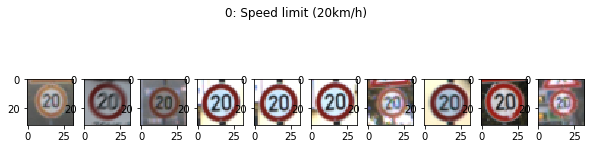

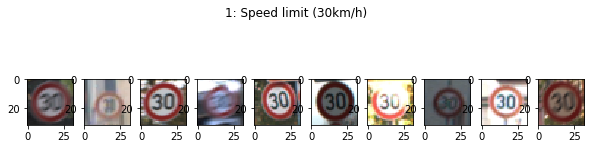

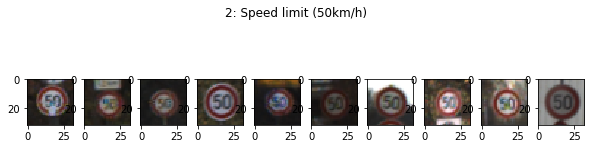

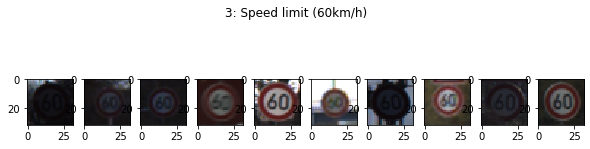

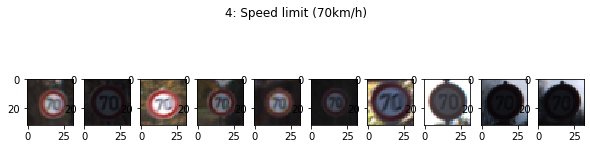

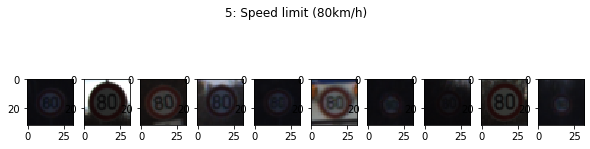

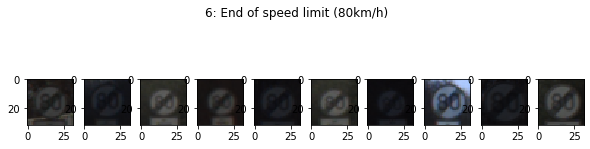

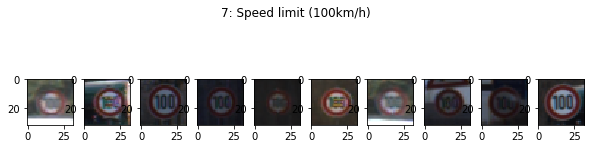

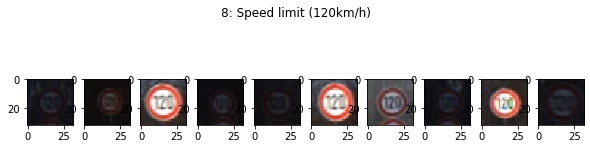

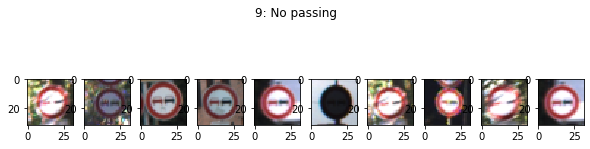

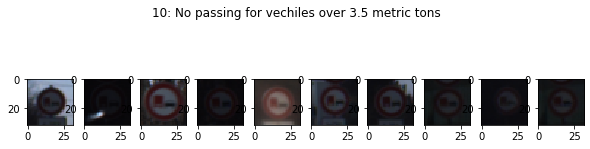

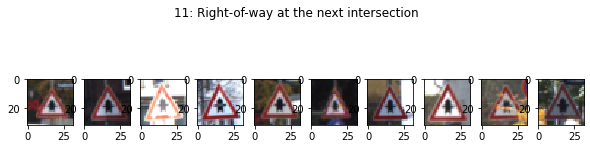

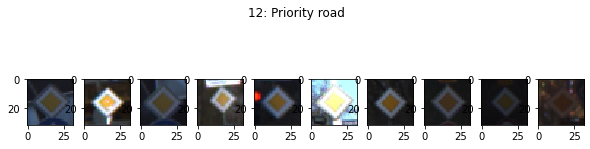

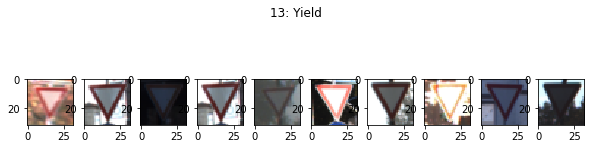

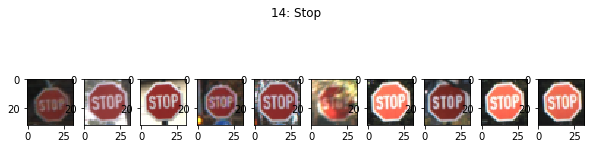

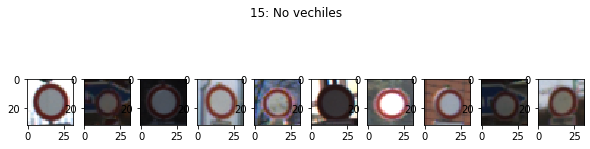

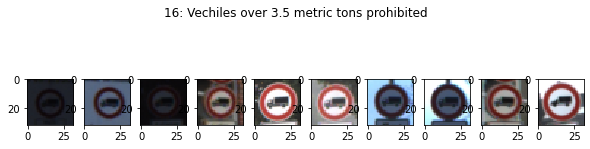

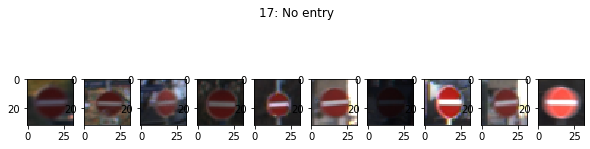

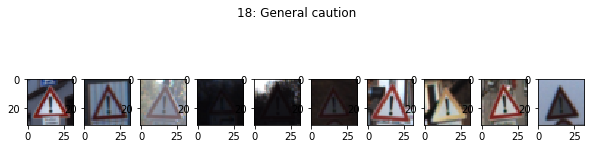

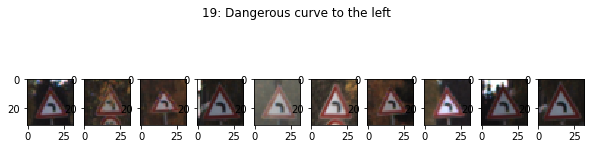

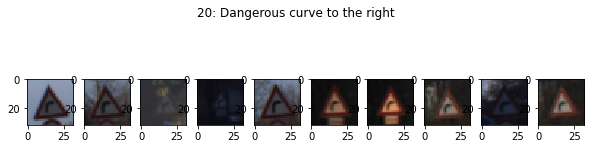

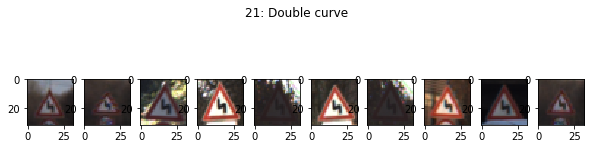

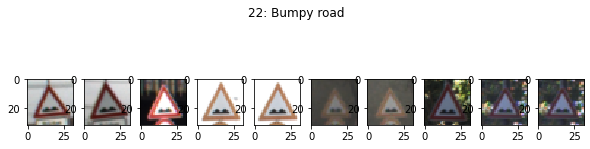

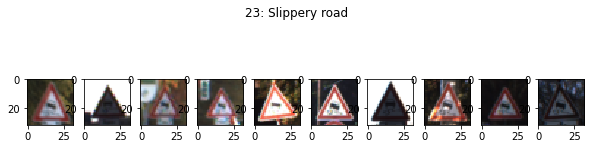

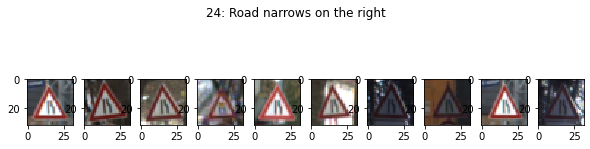

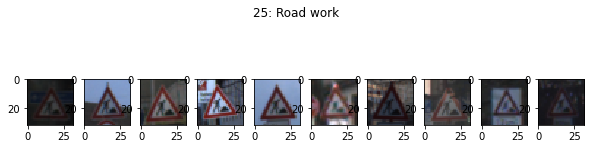

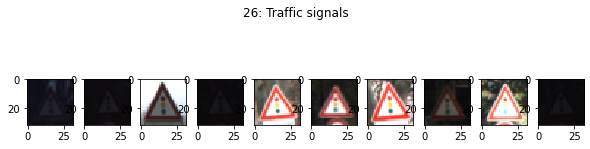

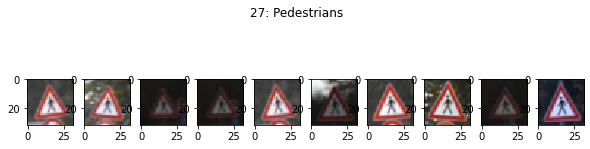

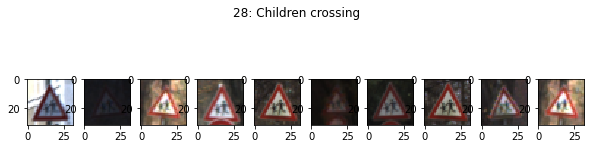

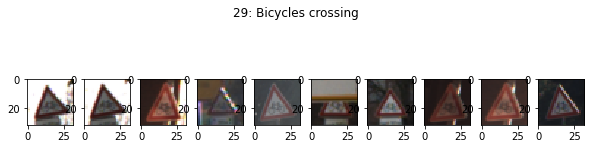

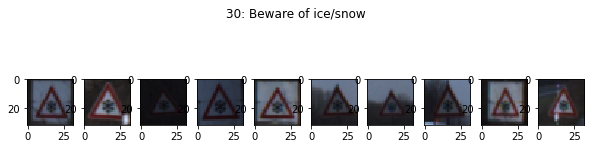

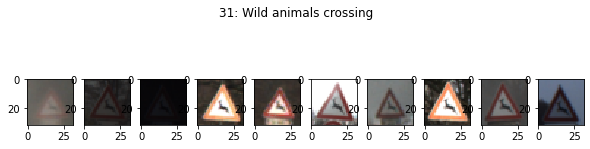

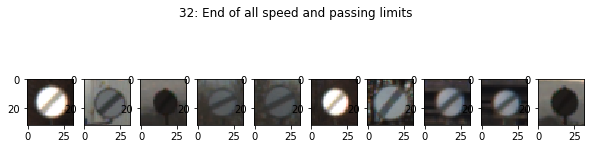

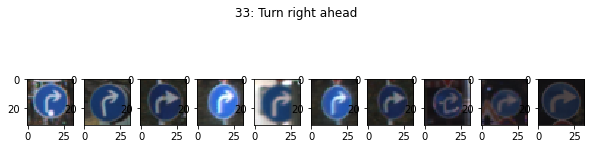

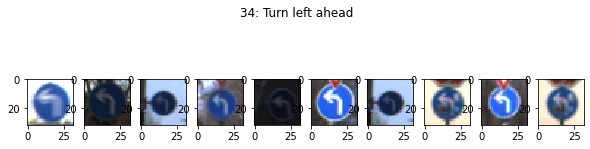

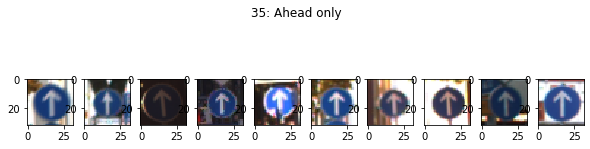

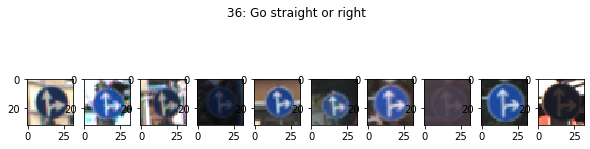

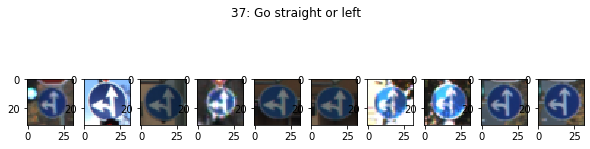

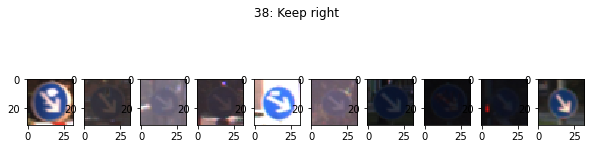

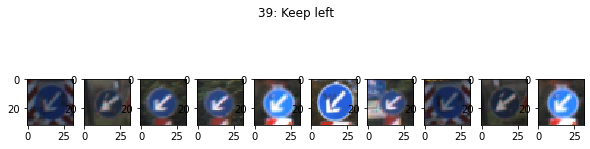

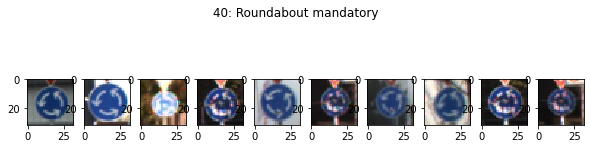

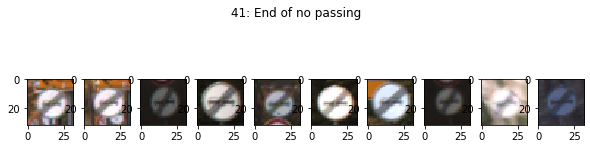

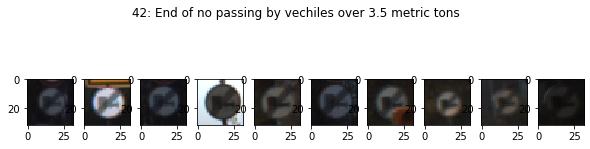

In [ ]:
import csv
import random

with open('/content/gdrive/MyDrive/tps/last_tp/Signnames.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader, None)
    sign_names = list(reader)
    
labels = np.unique(y_train)
for label in labels:
    label_indices = np.where(y_train==label)[0]
    fig = plt.figure(figsize=(10, 10))
    for i in range(10):
        rand_index = random.choice(label_indices)
        sub = fig.add_subplot(10, 10, i+1)
        sub.imshow(X_train[rand_index], interpolation='nearest')
    plt.suptitle(str(label) + ': ' + sign_names[label][1])
    plt.show()

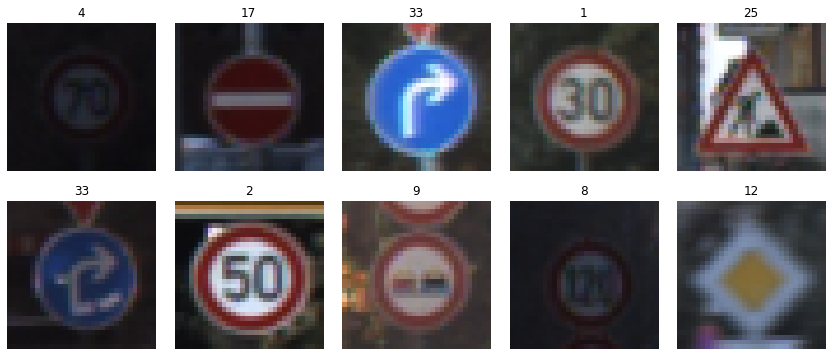

In [ ]:
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

# show image of 10 random data points
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

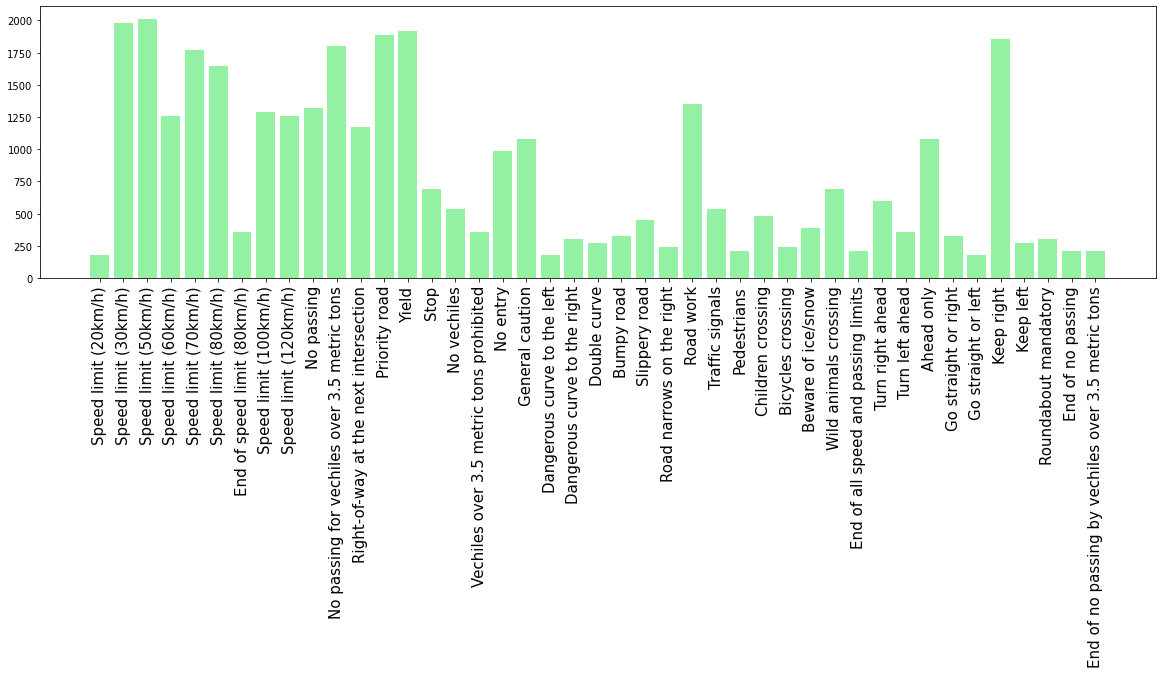

In [ ]:
plt.figure(figsize=(20,5))
item, count = np.unique(y_train, return_counts=True)
#names is a list of traffic signs, Remember that we already have a list : signs
names = signs
y_pos = np.arange(len(names))
plt.bar(item, count, alpha=0.6, color = (0.3,0.9,0.4,0.6) )

plt.xticks(y_pos, names, fontsize=15, rotation=90)

plt.show()

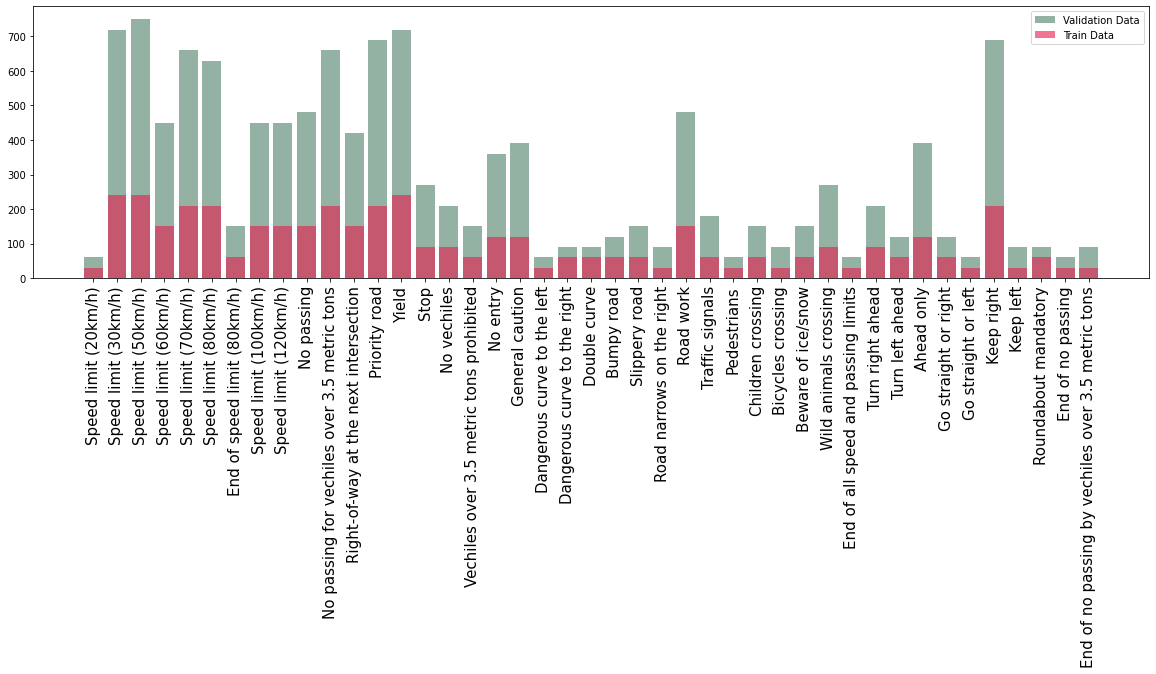

In [ ]:
plt.figure(figsize=(20,5))
item, count = np.unique(y_test, return_counts=True)
item1, count1 = np.unique(y_valid, return_counts=True)

names = signs
names1 = []

y_pos = np.arange(len(names))
plt.bar(item, count, alpha=0.6, color = (0.3,0.5,0.4,0.2), label="Validation Data" )

plt.bar(item1, count1, alpha=0.6, color = (0.9,0.1,0.3,0.2), label="Train Data" )

plt.xticks(y_pos, names, fontsize=15, rotation=90)
plt.legend()
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [ ]:
# gray scale
X_test_gry = np.sum(X_test/3, axis=3, keepdims=True)
X_train_gry = np.sum(X_train/3, axis=3, keepdims=True)
X_valid_gry = np.sum(X_valid/3, axis=3, keepdims=True)

In [ ]:
# normalization Here 
X_train_gry = (X_train_gry - 128)/128
X_test_gry = (X_test_gry - 128)/128
X_valid_gry = (X_valid_gry - 128)/128


In [ ]:
X_train_gry

array([[[[-0.79947917],
         [-0.80729167],
         [-0.80989583],
         ...,
         [-0.78125   ],
         [-0.78385417],
         [-0.78125   ]],

        [[-0.79166667],
         [-0.8046875 ],
         [-0.8046875 ],
         ...,
         [-0.78125   ],
         [-0.78645833],
         [-0.78645833]],

        [[-0.79166667],
         [-0.8046875 ],
         [-0.80729167],
         ...,
         [-0.78125   ],
         [-0.78645833],
         [-0.78645833]],

        ...,

        [[-0.80729167],
         [-0.79947917],
         [-0.79427083],
         ...,
         [-0.80729167],
         [-0.80729167],
         [-0.80208333]],

        [[-0.80729167],
         [-0.79947917],
         [-0.79166667],
         ...,
         [-0.80729167],
         [-0.80729167],
         [-0.80989583]],

        [[-0.8046875 ],
         [-0.796875  ],
         [-0.79427083],
         ...,
         [-0.80989583],
         [-0.81510417],
         [-0.82291667]]],


       [[[-0.80208333],


In [ ]:
# Shuffle your data here 
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train_gry, trainY)
X_validation, y_validation = shuffle(X_valid_gry, y_valid)
testX, testY = shuffle(X_test_gry, y_test)

shape in/out: (32, 32, 1) (32, 32, 1)


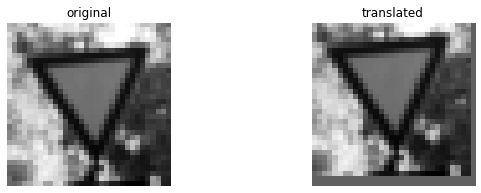

In [ ]:
import cv2

def random_translate(img):
    rows,cols,_ = img.shape
    
    # allow translation up to px pixels in x and y directions
    px = 2
    dx,dy = np.random.randint(-px,px,2)

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

test_img = X_train_gry[22222]

test_dst = random_translate(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('translated')

print('shape in/out:', test_img.shape, test_dst.shape)

Next cells should be useful for data augmentation

shape in/out: (32, 32, 1) (32, 32, 1)


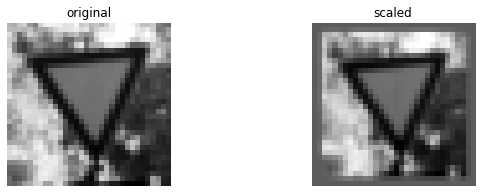

In [ ]:
def random_scaling(img):   
    rows,cols,_ = img.shape

    # transform limits
    px = np.random.randint(-2,2)

    # ending locations
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])

    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(rows,cols))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

test_dst = random_scaling(test_img)
    
fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('scaled')

print('shape in/out:', test_img.shape, test_dst.shape)


shape in/out: (32, 32, 1) (32, 32, 1)


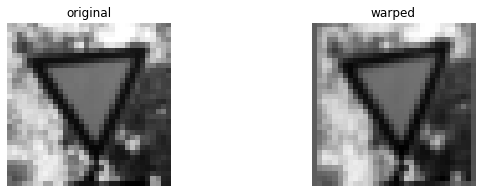

In [ ]:
def random_warp(img):
    
    rows,cols,_ = img.shape

    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= cols * 0.06   # this coefficient determines the degree of warping
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

test_dst = random_warp(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('warped')

print('shape in/out:', test_img.shape, test_dst.shape)

shape in/out: (32, 32, 1) (32, 32, 1)


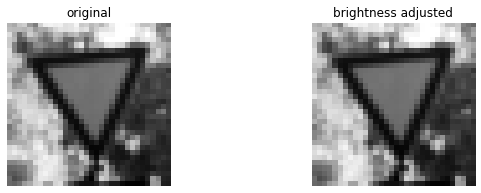

In [ ]:
def random_brightness(img):
    shifted = img + 1.0   # shift to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0
    return dst

test_dst = random_brightness(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('brightness adjusted')

print('shape in/out:', test_img.shape, test_dst.shape)

In [ ]:
print('X, y shapes:', X_train_gry.shape, y_train.shape)

input_indices = []
output_indices = []

for class_n in range(n_classes):
     class_indices = np.where(y_train == class_n)
     n_samples = len(class_indices[0])
     if 0< n_samples < 800:
         for i in range(800 - n_samples):
           input_indices.append(class_indices[0][i% n_samples])
           output_indices.append(X_train_gry.shape[0])
           new_img = X_train_gry[class_indices[0][i % n_samples]]
           new_img = random_translate(random_scaling(random_warp(random_brightness(new_img))))
           new_X_train = np.concatenate((X_train_gry, [new_img]), axis=0)
           y_train = np.concatenate((y_train, [class_n]), axis=0)
data_file = "/content/gdrive/MyDrive/tps/last_tp/new_train.p"
pickle.dump({"images":X_train_gry,"labels":y_train},open(data_file,"wb"),protocol=4)

X, y shapes: (34799, 32, 32, 1) (34799, 43)


In [ ]:
# if u do have a file that contains new_train data RUN ME
with open("/content/gdrive/MyDrive/tps/last_tp/new_train.p","rb") as f:
    data = pickle.load(f)
X_train,y_train = data["images"],data["labels"]


In [ ]:
# Shuffle your data here 
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train_gry, y_train)
X_validation, y_validation = shuffle(X_valid_gry, y_valid)
testX, testY = shuffle(X_test_gry, y_test)

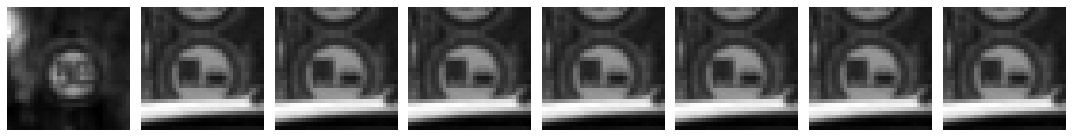

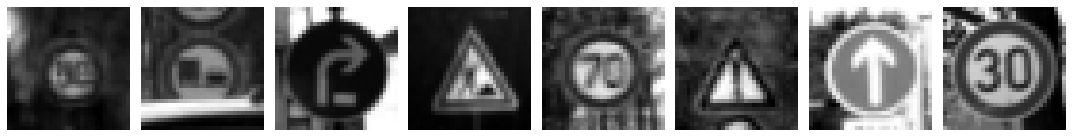

In [ ]:
def plot_figures_no_labels(figures, nrows = 1, ncols=1):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 15))
    axs = axs.ravel()
    for index, title in zip(range(len(figures)), figures):
        axs[index].imshow(figures[title], plt.gray())
        axs[index].set_axis_off()
        
    plt.tight_layout()
    plt.show()
    
for class_n in range(n_classes): # you should range for all classes 
  figures = {}

  class_indices = list (np.where(y_train == class_n)[0])
  
  for i in range(8):
    
        figures[i] = X_train[class_indices[-i]].squeeze()
      
  plot_figures_no_labels(figures, 1, 8)

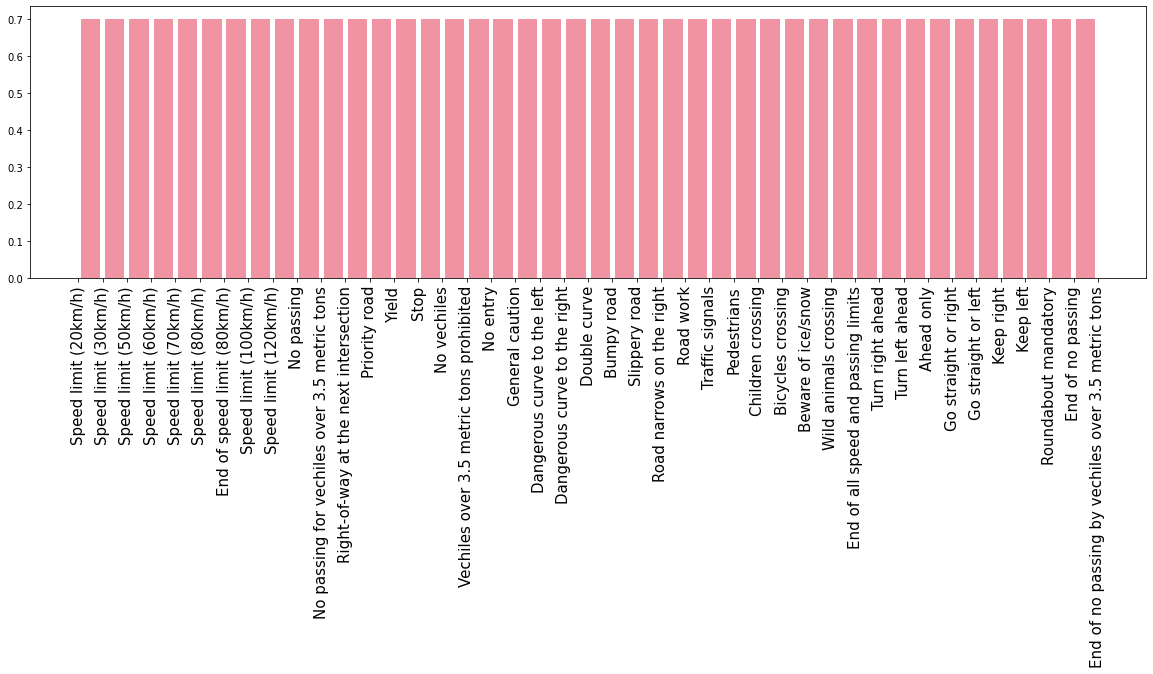

In [ ]:
plt.figure(figsize=(20,5))
item, count = np.unique(y_train, return_counts=True)
names = signs
y_pos = np.arange(len(names))
width = 0.7 * (y_pos[1] - y_pos[0])
center = (y_pos[:-1] + y_pos[1:])/2
plt.bar(center, width, alpha=0.6, color = (0.9,0.3,0.4,0.6) )
plt.xticks(y_pos, names, fontsize=15, rotation=90)
plt.show()

### Model Architecture

In [ ]:
IMAGE_SIZE = [32, 32]
epochs = 100
batch_size = 64
image_input = Input(shape=(32, 32, 1))


In [ ]:
import pickle


train_file = open("/content/gdrive/MyDrive/tps/last_tp/train.p", "rb")
train_data_full = pickle.load(train_file)
train_file.close()

valid_file = open("/content/gdrive/MyDrive/tps/last_tp/valid.p", "rb")
valid_data_full = pickle.load(valid_file)
valid_file.close()

test_file = open("/content/gdrive/MyDrive/tps/last_tp/test.p", "rb")
test_data_full = pickle.load(test_file)
test_file.close()

In [ ]:
print(train_data_full.keys())
print("features shape: ", train_data_full["features"].shape)
print("labels shape: ", train_data_full["labels"].shape)

dict_keys(['coords', 'labels', 'features', 'sizes'])
features shape:  (34799, 32, 32, 3)
labels shape:  (34799,)


In [ ]:
train_data = train_data_full["features"]
valid_data = valid_data_full["features"]
test_data = test_data_full["features"]


In [ ]:
from tensorflow.keras.utils import to_categorical
# normalization
train_data = train_data/255.0
valid_data = valid_data/255.0
test_data = test_data/255.0

# prepare labels
train_labels = to_categorical(train_data_full["labels"]) 
valid_labels = to_categorical(valid_data_full["labels"])
test_labels = to_categorical(test_data_full["labels"])

In [ ]:
valid_labels.shape

(4410, 43)

In [ ]:
conv_base = VGG19(input_shape = (32,32,3), include_top = False, weights = "imagenet")

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
from keras import models
import keras
from keras import layers

In [ ]:
dense_model = keras.Sequential()
dense_model.add(conv_base)
dense_model. add(layers.Flatten())
dense_model. add(layers.Dense(units = 80, activation = "relu"))
dense_model. add(layers.Dense(units = n_classes, activation = "softmax"))

initial_weights = dense_model.get_weights() # save the initial weights for the later use
dense_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 80)                41040     
                                                                 
 dense_1 (Dense)             (None, 43)                3483      
                                                                 
Total params: 20,068,907
Trainable params: 20,068,907
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras import optimizers

dense_model.set_weights(initial_weights) # restore the initial weights in order to start the training from the beginning on every run of the cell
optimizer_use = tf.optimizers.Adam()
dense_model.compile(optimizer = optimizer_use, loss = "categorical_crossentropy", metrics = ["categorical_accuracy"])
history = dense_model.fit(train_data, train_labels, epochs = 20, batch_size = 32, validation_data = (valid_data, valid_labels))

Epoch 1/20
1088/1088 [==============================] - 97s 80ms/step - loss: 2.6832 - categorical_accuracy: 0.2043 - val_loss: 1.9664 - val_categorical_accuracy: 0.3451
Epoch 2/20
1088/1088 [==============================] - 87s 80ms/step - loss: 1.4109 - categorical_accuracy: 0.5113 - val_loss: 1.1572 - val_categorical_accuracy: 0.6095
Epoch 3/20
1088/1088 [==============================] - 86s 79ms/step - loss: 0.7657 - categorical_accuracy: 0.7178 - val_loss: 0.7200 - val_categorical_accuracy: 0.7381
Epoch 4/20
1088/1088 [==============================] - 85s 79ms/step - loss: 0.6052 - categorical_accuracy: 0.7843 - val_loss: 0.7994 - val_categorical_accuracy: 0.7485
Epoch 5/20
1088/1088 [==============================] - 85s 78ms/step - loss: 0.5008 - categorical_accuracy: 0.8239 - val_loss: 0.4764 - val_categorical_accuracy: 0.8594
Epoch 6/20
1088/1088 [==============================] - 85s 79ms/step - loss: 0.2646 - categorical_accuracy: 0.9148 - val_loss: 0.3899 - val_categoric

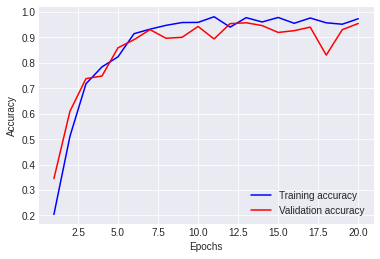

In [ ]:
acc_values = history.history['categorical_accuracy']
val_acc_values = history.history['val_categorical_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'r', label = 'Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_features_intermediate_2 = dense_model.predict(test_data)

In [ ]:
evals = dense_model.evaluate(test_labels, test_features_intermediate_2)

ValueError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix

predicted_classes = None
y_true = None

cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)

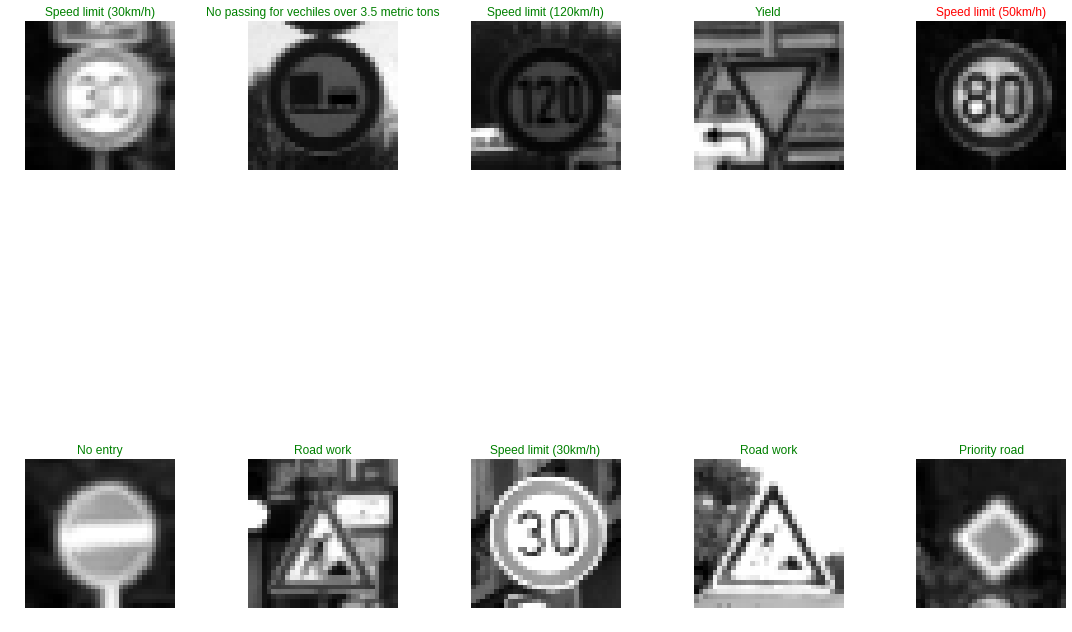

In [ ]:
# PLOT IMAGES WITH PREDICTED SIGNS

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

- In this case study, we want to classify images of traffic signs using deep Convolutional Neural Networks (CNNs).
- The dataset consists of 43 different classes of images. 
- Classes are as listed below: 
  - 0 = Speed limit (20km/h) 
  - 1 = Speed limit (30km/h)
  - 2 = Speed limit (50km/h) 
  - 3 = Speed limit (60km/h)
  - 4 = Speed limit (70km/h) 
  - 5 = Speed limit (80km/h)
  - 6 = End of speed limit (80km/h)
  - 7 = Speed limit (100km/h)
  - 8 = Speed limit (120km/h)
  - 9 = No passing
  - 10 = No passing for vehicles over 3.5 metric tons
  - 11 = Right-of-way at the next intersection
  - 12 = Priority road
  - 13 = Yield
  - 14 = Stop
  - 15 = No vehicles
  - 16 = Vehicles over 3.5 metric tons prohibited
  - 17 = No entry
  - 18 = General caution
  - 19 = Dangerous curve to the left
  - 20 = Dangerous curve to the right
  - 21 = Double curve
  - 22 = Bumpy road
  - 23 = Slippery road
  - 24 = Road narrows on the right
  - 25 = Road work
  - 26 = Traffic signals
  - 27 = Pedestrians
  - 28 = Children crossing 
  - 29 = Bicycles crossing
  - 30 = Beware of ice/snow
  - 31 = Wild animals crossing
  - 32 = End of all speed and passing limits
  - 33 = Turn right ahead
  - 34 = Turn left ahead
  - 35 = Ahead only
  - 36 = Go straight or right
  - 37 = Go straight or left
  - 38 = Keep right
  - 39 = Keep left
  - 40 = Roundabout mandatory
  - 41 = End of no passing
  - 42 = End of no passing by vehicles over 3.5 metric tons

- Citation
J. Stallkamp, M. Schlipsing, J. Salmen, and C. Igel. The German Traffic Sign Recognition Benchmark: A multi-class classification competition. In Proceedings of the IEEE International Joint Conference on Neural Networks, pages 1453–1460. 2011. 
@inproceedings{Stallkamp-IJCNN-2011, author = {Johannes Stallkamp and Marc Schlipsing and Jan Salmen and Christian Igel}, booktitle = {IEEE International Joint Conference on Neural Networks}, title = {The {G}erman {T}raffic {S}ign {R}ecognition {B}enchmark: A multi-class classification competition}, year = {2011}, pages = {1453--1460} }